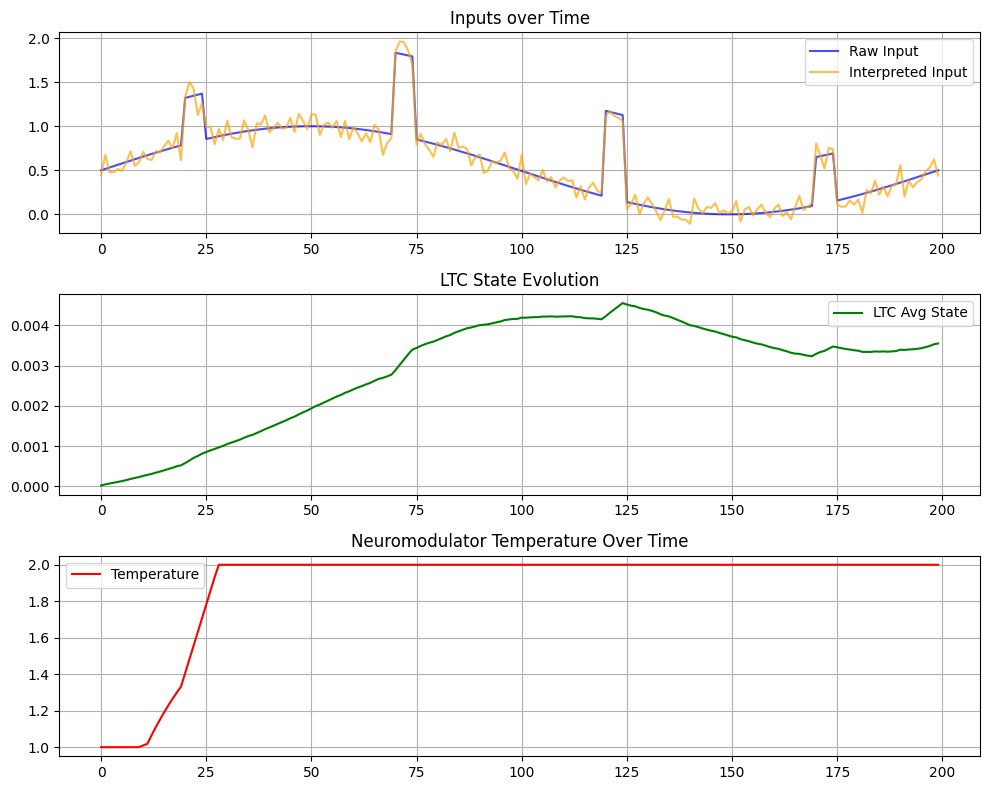

Discovered Patterns (Count): 2
Pattern 0: [0.00012247]
Pattern 1: [0.0001463]


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Assume previous classes from before: Neuromodulator, boltzmann_sample, LTCNeuron, HebbianLayer, LTCLayer

class PatternMemory:
    def __init__(self, similarity_threshold=0.9):
        self.patterns = []
        self.similarity_threshold = similarity_threshold

    def store_pattern(self, pattern):
        # Try to match against existing patterns
        best_score = 0.0
        best_idx = -1
        for i, p in enumerate(self.patterns):
            score = self.pattern_similarity(p, pattern)
            if score > best_score:
                best_score = score
                best_idx = i
        
        if best_score < self.similarity_threshold:
            # New pattern discovered
            self.patterns.append(pattern)
            return False  # new pattern
        else:
            # Known pattern matched
            return True  # known pattern

    def pattern_similarity(self, p1, p2):
        # Simple cosine similarity
        dot = np.dot(p1, p2)
        norm = np.linalg.norm(p1)*np.linalg.norm(p2)
        return dot/(norm+1e-9)


def generate_synthetic_data(steps=200):
    t = np.linspace(0, 2*np.pi, steps)
    base = np.sin(t)*0.5 + 0.5
    # Add random spikes
    for i in range(20, steps, 50):
        if i < steps:
            base[i:i+5] += np.random.rand()*0.5+0.5
    return base

def novelty_score_fn(input_val):
    # Novelty high if input_val > 0.8 or <0.2
    if input_val > 0.8 or input_val < 0.2:
        return 1.0
    else:
        return 0.1

class Neuromodulator:
    def __init__(self, initial_temp=1.0, min_temp=0.1, max_temp=2.0):
        self.temperature = initial_temp
        self.min_temp = min_temp
        self.max_temp = max_temp
        self.dopamine_level = 0.0
        
    def update(self, novelty_score):
        if novelty_score > 0.5:
            self.dopamine_level += 0.05 * (novelty_score - 0.5)
        else:
            self.dopamine_level *= 0.95
        self.temperature = np.clip(1.0 + self.dopamine_level, self.min_temp, self.max_temp)
    def get_temperature(self):
        return self.temperature

def boltzmann_sample(base_input, neuromodulator):
    candidates = []
    for _ in range(5):
        perturbed = base_input + np.random.randn(*base_input.shape)*0.1
        candidates.append(perturbed)
    energies = []
    for c in candidates:
        dist = np.linalg.norm(c - base_input)
        energies.append(-dist)
    T = neuromodulator.get_temperature()
    probs = np.exp(np.array(energies)/T)
    probs /= probs.sum()
    choice = np.random.choice(len(candidates), p=probs)
    return candidates[choice], probs[choice]

class LTCNeuron:
    def __init__(self, tau=1.0):
        self.state = np.zeros(1)
        self.tau = tau
    def update(self, input_signal, dt=0.1):
        dstate = (1/self.tau)*(input_signal - self.state)*dt
        self.state += dstate
        return self.state

class LTCLayer:
    def __init__(self, num_neurons=3, tau=1.0):
        self.neurons = [LTCNeuron(tau=tau*(1+0.1*i)) for i in range(num_neurons)]
    def update(self, inputs, dt=0.1):
        # inputs could be scalar (shape (1,)) or vector
        # If vector, ensure shape matches. Let's assume scalar for simplicity
        states = [n.update(inputs, dt)[0] for n in self.neurons]
        return np.array(states), np.mean(states)

class HebbianLayer:
    def __init__(self, input_dim, output_dim, eta=0.01):
        self.weights = np.random.randn(output_dim, input_dim)*0.01
        self.eta = eta
    def forward(self, inputs):
        return self.weights @ inputs
    def hebbian_update(self, inputs, outputs):
        dw = self.eta * np.outer(outputs, inputs)
        self.weights += dw

# Create some layers stack
hebb = HebbianLayer(input_dim=1, output_dim=3, eta=0.01)
ltc_layer = LTCLayer(num_neurons=3, tau=1.0)
neuromodulator = Neuromodulator()
pattern_memory = PatternMemory(similarity_threshold=0.95)

base_input = generate_synthetic_data(200)

state_history = []
temp_history = []
raw_input_history = []
interpretation_history = []

window_size = 10  # We'll check stability over last 10 steps
recent_states = []

for i, val in enumerate(base_input):
    raw_in = np.array([val])
    nov = novelty_score_fn(raw_in[0])
    neuromodulator.update(nov)

    # Boltzmann pre-stage
    interpreted_input, chosen_prob = boltzmann_sample(raw_in, neuromodulator)
    
    # Hebbian layer
    hebb_out = hebb.forward(interpreted_input)
    
    # LTC layer
    states, avg_state = ltc_layer.update(np.array([np.mean(hebb_out)]), dt=0.01)

    # Hebbian update
    hebb.hebbian_update(interpreted_input, hebb_out)

    state_history.append(avg_state)
    temp_history.append(neuromodulator.get_temperature())
    raw_input_history.append(raw_in[0])
    interpretation_history.append(interpreted_input[0])

    recent_states.append(avg_state)
    if len(recent_states) > window_size:
        recent_states.pop(0)
    # Check stability - if variance in last window is low, we found a stable attractor
    if len(recent_states) == window_size:
        variance = np.var(recent_states)
        if variance < 0.0001:  # Arbitrary threshold for "stability"
            # We got a stable pattern, store it
            stable_pattern = np.mean(recent_states)
            stable_pattern_vec = np.array([stable_pattern])  # If more dims, we'd store vector
            known = pattern_memory.store_pattern(stable_pattern_vec)
            if known:
                # Known pattern recognized -> internal reward or a dopamine tweak
                neuromodulator.dopamine_level += 0.05
            else:
                # New pattern discovered
                neuromodulator.dopamine_level += 0.01  # smaller reward, just for novelty

# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,8))

ax1.plot(raw_input_history, label='Raw Input', color='blue', alpha=0.7)
ax1.plot(interpretation_history, label='Interpreted Input', color='orange', alpha=0.7)
ax1.set_title('Inputs over Time')
ax1.legend(); ax1.grid(True)

ax2.plot(state_history, label='LTC Avg State', color='green')
ax2.set_title('LTC State Evolution')
ax2.legend(); ax2.grid(True)

ax3.plot(temp_history, label='Temperature', color='red')
ax3.set_title('Neuromodulator Temperature Over Time')
ax3.legend(); ax3.grid(True)

plt.tight_layout()
plt.show()

print("Discovered Patterns (Count):", len(pattern_memory.patterns))
for i, p in enumerate(pattern_memory.patterns):
    print(f"Pattern {i}: {p}")